In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# File which have Typology of gentrification
gdf = gpd.read_file("losangeles.gpkg")

In [3]:
cdc_data_15 = pd.read_csv('500_cities_data_15.csv')
cdc_data_18 = pd.read_csv('500_cities_data_18.csv')
cdc_data_19 = pd.read_csv('500_cities_data_19.csv')
cdc_data_21 = pd.read_csv('500_cities_data_21.csv')
cdc_data_22 = pd.read_csv('500_cities_data_22.csv')

In [4]:
cdc_data_15 = cdc_data_15.rename(columns={
    "PlaceName": "CountyName",
    "MHLTH_CrudePrev": "MentalHealth_2015"
})
cdc_data_18 = cdc_data_18.rename(columns={
    "MHLTH_CrudePrev": "MentalHealth_2018"
})
cdc_data_19 = cdc_data_19.rename(columns={
    "MHLTH_CrudePrev": "MentalHealth_2019"
})
cdc_data_21 = cdc_data_21.rename(columns={
    "MHLTH_CrudePrev": "MentalHealth_2021"
})
cdc_data_22 = cdc_data_22.rename(columns={
    "MHLTH_CrudePrev": "MentalHealth_2022"
})

In [5]:
datasets = [cdc_data_15, cdc_data_18, cdc_data_18, cdc_data_21, cdc_data_22]
years = [2015, 2018, 2019, 2021, 2022]

for year, df in zip(years, datasets):
    la_df = df[df["CountyName"].str.contains("Los Angeles", case=False, na=False)].copy()
    print(f"Year {year}: Los Angeles shape = {la_df.shape}")


Year 2015: Los Angeles shape = (994, 63)
Year 2018: Los Angeles shape = (2324, 63)
Year 2019: Los Angeles shape = (2324, 63)
Year 2021: Los Angeles shape = (2324, 81)
Year 2022: Los Angeles shape = (2474, 88)


In [6]:
# Ensure TractFIPS is string, stripped, and zero-padded for all datasets
for df in [cdc_data_18, cdc_data_19, cdc_data_21, cdc_data_22]:
    df["TractFIPS"] = df["TractFIPS"].astype(str).str.strip().str.replace(r"\.0$", "", regex=True).str.zfill(11)


In [7]:
la_18 = cdc_data_18[cdc_data_18["CountyName"].str.contains("Los Angeles", case=False, na=False)].copy()
la_19 = cdc_data_19[cdc_data_19["CountyName"].str.contains("Los Angeles", case=False, na=False)].copy()
la_21 = cdc_data_21[cdc_data_21["CountyName"].str.contains("Los Angeles", case=False, na=False)].copy()
la_22 = cdc_data_22[cdc_data_22["CountyName"].str.contains("Los Angeles", case=False, na=False)].copy()

In [8]:
la_18 = la_18[["TractFIPS", "MentalHealth_2018"]]
la_19 = la_19[["TractFIPS", "MentalHealth_2019"]]
la_21 = la_21[["TractFIPS", "MentalHealth_2021"]]
la_22 = la_22[["TractFIPS", "MentalHealth_2022"]]

In [9]:
la_df = (
    la_22
    .merge(la_18, on="TractFIPS", how="left")
    .merge(la_19, on="TractFIPS", how="left")
    .merge(la_21, on="TractFIPS", how="left")
)

In [10]:
for col in ["MentalHealth_2018", "MentalHealth_2019", "MentalHealth_2021", "MentalHealth_2022"]:
    print(f"{col} missing:", la_df[col].isna().sum())


MentalHealth_2018 missing: 474
MentalHealth_2019 missing: 474
MentalHealth_2021 missing: 474
MentalHealth_2022 missing: 0


In [12]:
la_df["TractFIPS"] = la_df["TractFIPS"].astype(str).str.strip().str.zfill(11)
gdf["GEOID"] = gdf["GEOID"].astype(str).str.strip().str.replace(r"\.0$", "", regex=True).str.zfill(11)

merged_df = la_df.merge(
    gdf,
    how="inner", # Removing NA
    left_on="TractFIPS",
    right_on="GEOID"
)

print("Merged dataframe shape:", merged_df.shape)
print("Gentrification data available for:", merged_df['GEOID'].notna().sum(), "tracts")


Merged dataframe shape: (2000, 8)
Gentrification data available for: 2000 tracts


In [13]:
len(merged_df["TractFIPS"].unique())
# Each tract is diffrent so can't categorize it further like cant see which tract takes more space in mental health.

2000

In [14]:
sns.set(style="whitegrid")

# Columns to consider
mh_cols = ["MentalHealth_2018", "MentalHealth_2019", "MentalHealth_2021", "MentalHealth_2022", "Typology"]

plot_df = merged_df[mh_cols].melt(id_vars="Typology",
                                  value_vars=["MentalHealth_2018", "MentalHealth_2019", "MentalHealth_2021", "MentalHealth_2022"],
                                  var_name="Year",
                                  value_name="MentalHealth")

plot_df["Year"] = plot_df["Year"].str.replace("MentalHealth_", "")

avg_df = plot_df.groupby(["Typology", "Year"])["MentalHealth"].mean().reset_index()

avg_df["Typology"] = avg_df["Typology"].astype(str)
avg_df = avg_df.sort_values("Typology")


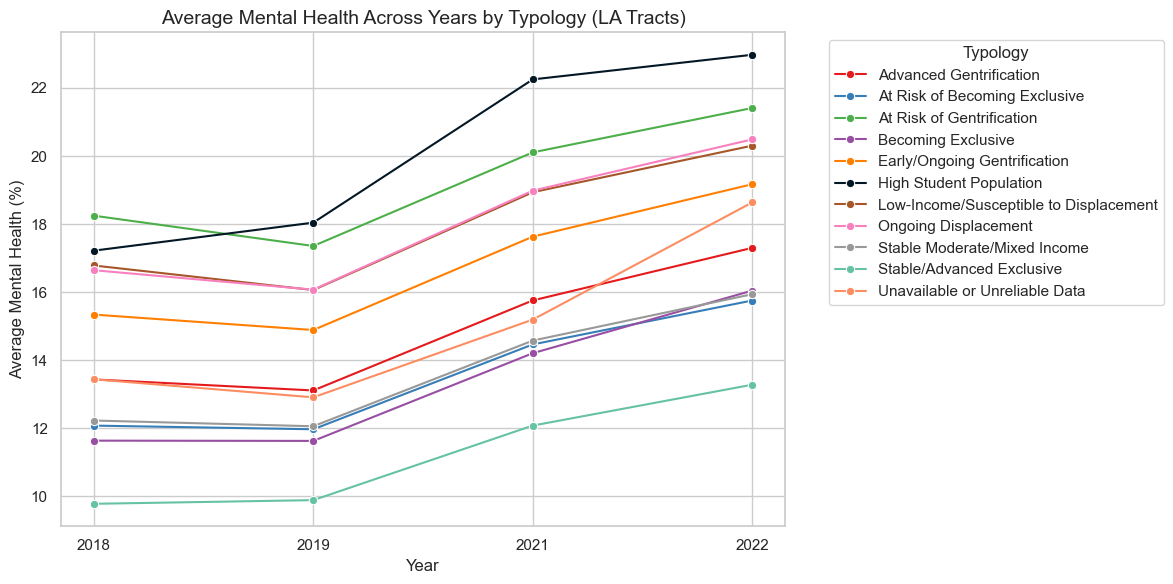

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))

# 11 custom distinct colors
custom_colors = [
    "#e41a1c",  
    "#377eb8", 
    "#4daf4a", 
    "#984ea3", 
    "#ff7f00", 
    "#031725",
    "#a65628", 
    "#f781bf", 
    "#999999", 
    "#66c2a5", 
    "#fc8d62"  
]

sns.lineplot(
    data=avg_df,
    x="Year",
    y="MentalHealth",
    hue="Typology",
    marker="o",
    palette=custom_colors
)

plt.title("Average Mental Health Across Years by Typology (LA Tracts)", fontsize=14)
plt.ylabel("Average Mental Health (%)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Typology", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [23]:
# FOR YEAR 2018

In [24]:
merged_df.columns

Index(['TractFIPS', 'MentalHealth_2022', 'MentalHealth_2018',
       'MentalHealth_2019', 'MentalHealth_2021', 'GEOID', 'Typology',
       'geometry'],
      dtype='object')

C:\Users\dhair\AppData\Local\Temp\ipykernel_19728\3169777466.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


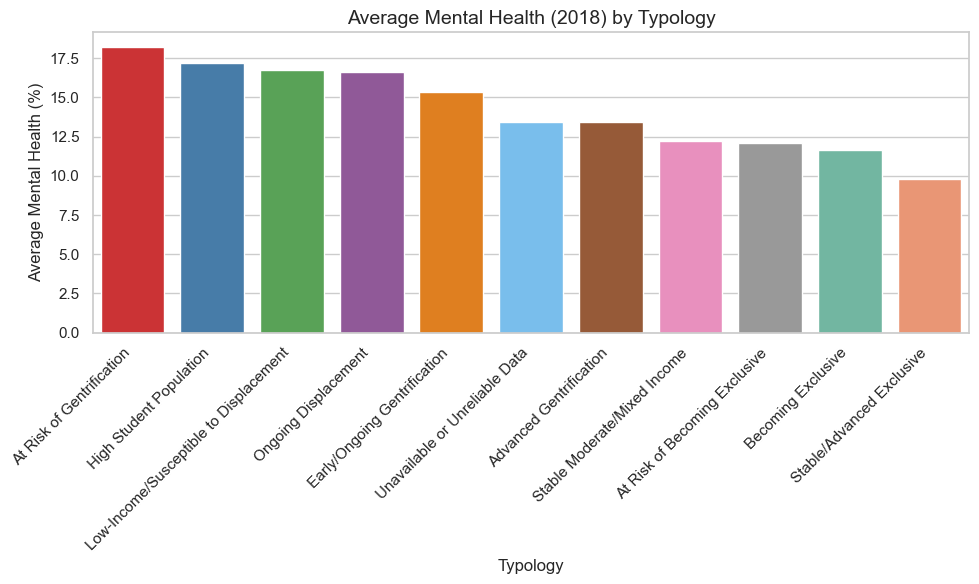

In [ ]:
avg_2018 = merged_df.groupby('Typology')['MentalHealth_2018'].mean().reset_index()
avg_2018 = avg_2018.sort_values('MentalHealth_2018', ascending=False)

plt.figure(figsize=(10,6))

sns.barplot(
    data=avg_2018,
    x='Typology',
    y='MentalHealth_2018',
    palette=[
        "#e41a1c", "#377eb8", "#4daf4a", "#984ea3",
        "#ff7f00", "#66c2ff", "#a65628", "#f781bf",
        "#999999", "#66c2a5", "#fc8d62"
    ]
)

plt.title("Average Mental Health (2018) by Typology", fontsize=14)
plt.ylabel("Average Mental Health (%)", fontsize=12)
plt.xlabel("Typology", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [30]:
avg_2018.columns

Index(['Typology', 'MentalHealth_2018'], dtype='object')

C:\Users\dhair\AppData\Local\Temp\ipykernel_19728\2146980587.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


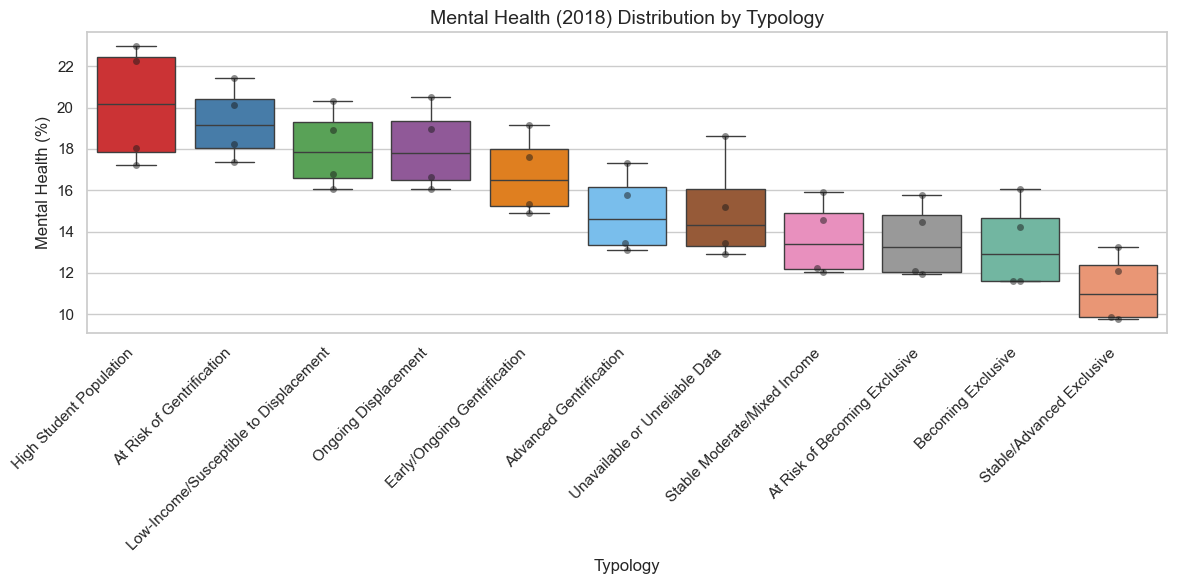

In [ ]:
custom_colors = [
    "#e41a1c", "#377eb8", "#4daf4a", "#984ea3",
    "#ff7f00", "#66c2ff", "#a65628", "#f781bf",
    "#999999", "#66c2a5", "#fc8d62"
]

typology_order = avg_df.groupby('Typology')['MentalHealth'].median().sort_values(ascending=False).index

plt.figure(figsize=(12,6))

# Boxplot
sns.boxplot(
    data=avg_df,
    x='Typology',
    y='MentalHealth',
    order=typology_order,
    palette=custom_colors
)

# Overlay points
sns.swarmplot(
    data=avg_df,
    x='Typology',
    y='MentalHealth',
    order=typology_order,
    color='k',
    alpha=0.5
)

plt.xticks(rotation=45, ha='right')
plt.title("Mental Health (2018) Distribution by Typology", fontsize=14)
plt.ylabel("Mental Health (%)", fontsize=12)
plt.xlabel("Typology", fontsize=12)
plt.tight_layout()
plt.show()
